In [120]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

from numba import jit
from statsmodels.tools.numdiff import approx_fprime, approx_hess

#import arch

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""

# pandas-datareader
from pandas_datareader.yahoo.daily import YahooDailyReader

# plotting
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart, correlation_plot, fan_chart

# Views
from codelib.portfolio_optimization.views import ProbabilitySolver, CorrelationView,MeanView, VolatilityView, weighted_percentile
from codelib.portfolio_optimization.views import effective_sample_size_entropy, calculate_correlation, View
from codelib.portfolio_optimization.views import calculate_correlation, calculate_variance, calculate_std, calculate_covariance
from codelib.portfolio_optimization.views import calculate_skewness, calculate_kurtosis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Retake Exam 2021 - Volatility and historical scenarios

# Guided Solution

Below, I will examplify how to solve the problems. I will not, necessarily, provide the full solution. 

# Problem 1: The GARCH(1, 1) model - A simple model for time-varying volatility 

First, we obtain the index values of SP500, calculate log-returns and plot the returns and squared returns. 

In [121]:
"""
Get adjusted index prices for SP500.
"""
tickers = ["^GSPC"]
df_sp500 = YahooDailyReader(tickers, start=datetime.date(2000, 1, 1)).read()

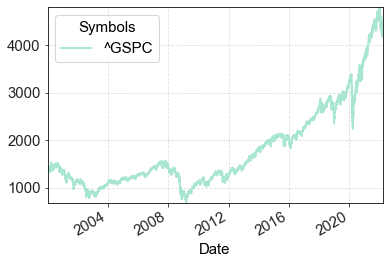

In [122]:
df_sp500['Adj Close'].plot();

In [123]:
df_sp500_log_returns = np.log(df_sp500['Adj Close'] / df_sp500['Adj Close'].shift(1)).dropna()

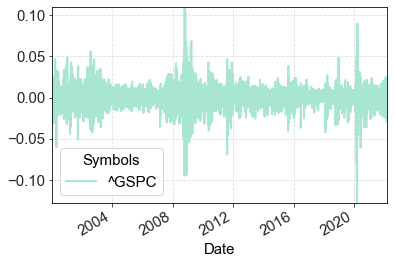

In [124]:
df_sp500_log_returns.plot();

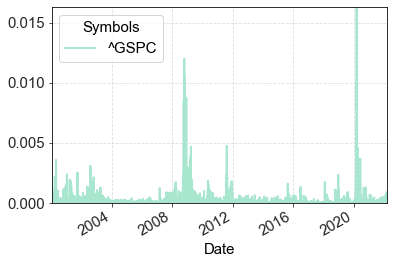

In [125]:
(df_sp500_log_returns**2).plot();

We see that large values of the squared returns are clustered in-line with the idea that financial market volatility tends to cluster. 

__The GARCH(1,1) model__

The GARCH(1,1) model of  can be written as 
\begin{align*}
	r_t &= \mu + h_t \varepsilon_t \\
	h_t &= \omega + \beta h_{t-1} + \alpha \varepsilon_{t-1}^2
\end{align*}

We want to calculate the conditional variance when $\mu=0$, $\omega = 0.02$, $\alpha=0.13$, $\beta = 0.86$ and returns are in percent. First, we define the GARCH recursion / filter. 

In [126]:
"""
Define relevant functions
"""

@jit
def garch_recursion(mu, omega, alpha, beta, returns):
    
    num_obs = len(returns)
    conditional_variance = np.zeros(num_obs)
    
    resids = returns - mu
    
    conditional_variance[0] = omega / (1 - alpha - beta)
    
    for i in range(1, num_obs): 
        
        conditional_variance[i] = omega + alpha * resids[i - 1]**2 + beta * conditional_variance[i - 1]
    
    return conditional_variance

In [127]:
mu = 0
omega = 0.02
alpha = 0.13
beta = 0.86
sp500_log_returns = df_sp500_log_returns.values[:, 0] * 100

h = garch_recursion(mu, omega, alpha, beta, sp500_log_returns)

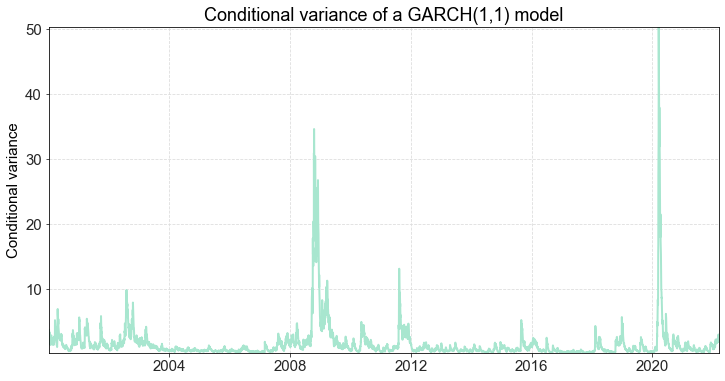

In [128]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_sp500_log_returns.index, h)
ax.set_ylabel("Conditional variance")
ax.set_title("Conditional variance of a GARCH(1,1) model");

__Maximum Likelihood__

The log-likelihood is given by

$$
\mathcal{L}(\mu, \omega, \alpha, \beta) = \sum_{t=1}^T \left[-\ln h_t - \frac{\varepsilon_t^2}{h_t} \right]
$$

We minimize with `scipy.optimize.minimize`, so when implementing the estimation procedure, we multiply with $-1$. 

In [129]:
"""
Define GARCH log-likelihood function (negative)
"""

def neg_logl_garch(params, returns, individual=False):
    
    # set parameters
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    
    # define error terms
    eps = returns - mu
    
    # get conditional variances
    h = garch_recursion(mu, omega, alpha, beta, returns)
    
    # get log-likehood function
    neg_logl = -(-np.log(h)- eps**2 / h)  #multiply with a minus as we want to maximize
    

    if individual: 
        return neg_logl
    else:
        return np.sum(neg_logl)

In [130]:
"""
Minimize neg. loglikelihood
"""

cons = {'type': 'ineq',
        'fun': lambda x: 0.999 - x[2] - x[3]}

init_params = np.array([0.0, 0.1, 0.05, 0.94])

res = minimize(neg_logl_garch, init_params, args=(sp500_log_returns),
             bounds = ((None, None), (0.0001, None), (0.0001, None),(0.0001, None)),
             constraints=cons, 
             options={'disp':True})


Optimization terminated successfully    (Exit mode 0)
            Current function value: 5081.101884885493
            Iterations: 21
            Function evaluations: 124
            Gradient evaluations: 21


C:\environments\python_for_fin_econ\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [131]:
res.x

array([0.06005608, 0.02330827, 0.13073685, 0.85617085])

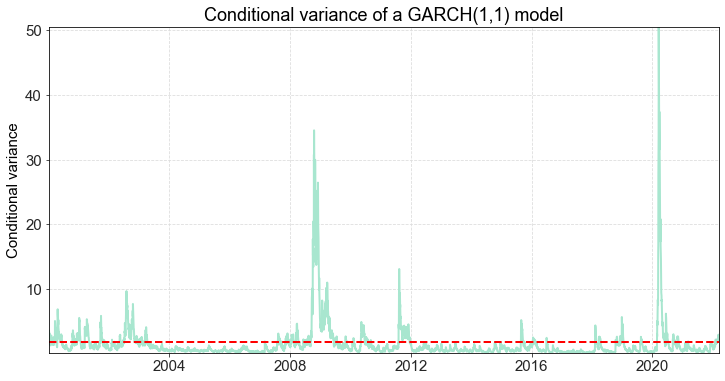

In [132]:
h = garch_recursion(res.x[0], res.x[1], res.x[2], res.x[3], sp500_log_returns)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_sp500_log_returns.index, h)
ax.axhline(y=res.x[1]/(1 - res.x[2] - res.x[3]), color='red', linestyle='--')
ax.set_ylabel("Conditional variance")
ax.set_title("Conditional variance of a GARCH(1,1) model");

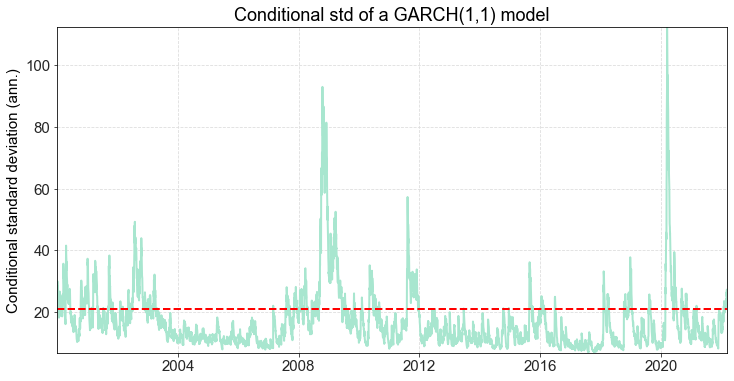

In [133]:
h = garch_recursion(res.x[0], res.x[1], res.x[2], res.x[3], sp500_log_returns)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_sp500_log_returns.index, np.sqrt(h) * np.sqrt(250))
ax.axhline(y=np.sqrt(res.x[1]/(1 - res.x[2] - res.x[3])) * np.sqrt(250), color='red', linestyle='--')
ax.set_ylabel("Conditional standard deviation (ann.)")
ax.set_title("Conditional std of a GARCH(1,1) model");

In [134]:
res

     fun: 5081.101884885493
     jac: array([ 0.10888672, -0.08587646, -0.04760742,  0.00622559])
 message: 'Optimization terminated successfully'
    nfev: 124
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([0.06005608, 0.02330827, 0.13073685, 0.85617085])

__Standard errors__

the log-likelihood estimator converges asymptotically to a multivariate normal ($\theta$ is the parameter vector and $\hat{}$ denotes the estimator)

$$
\sqrt{n} (\hat{\theta} - \theta_0) \to^d N(0, \mathbf{A}_0^{-1} \mathbf{B}_0 \mathbf{A}_0^{-1})
$$

In finite samples, we need to replace $\mathbf{A}_0$  and $\mathbf{B}_0$ with consistent estimators:

$$
\begin{align}
\hat{\mathbf{A}} & = \frac{1}{T} \sum_{t=1}^T \left. \frac{\partial^2 l_t(r_t ;\theta)}{\partial \theta \partial \theta^\top} \right \vert _{\theta = \hat{\theta}}  \\
\hat{\mathbf{B}} & = \frac{1}{T} \sum_{t=1}^T \left. \frac{\partial l_t(r_t ;\theta)}{\partial \theta } \frac{\partial l_t(r_t;\theta)}{\partial \theta^\top } \right \vert _{\theta = \hat{\theta}}
\end{align}
$$

where $l_t(r_t ;\theta)$ denotes the log-likelihood contribution at time $t$ 

$$
l_t(r_t ;\theta) = -\ln h_t - \frac{\varepsilon_t^2}{h_t}
$$

One may want to impose the information matrix equality. 

In [135]:
"""
Numerical scores
"""

scores = approx_fprime(res.x, neg_logl_garch, args=(sp500_log_returns, True))
B_approx = scores.T @ scores 

A_approx = -approx_hess(res.x, neg_logl_garch, args=(sp500_log_returns,))

param_mle_cov_A_num = np.linalg.inv(-A_approx)

param_mle_cov_B_num = np.linalg.inv(B_approx)

param_mle_cov_sandwich_num = np.linalg.inv(A_approx) @ B_approx @ np.linalg.inv(A_approx)

In [136]:
param_mle_cov_A_num

array([[ 5.59800215e-05,  6.60335433e-07,  4.99789518e-06,
        -4.60816219e-06],
       [ 6.60335433e-07,  4.77988267e-06,  6.81742231e-06,
        -1.12513456e-05],
       [ 4.99789518e-06,  6.81742231e-06,  5.02746018e-05,
        -4.52928878e-05],
       [-4.60816219e-06, -1.12513456e-05, -4.52928878e-05,
         5.03685219e-05]])

In [137]:
param_mle_cov_B_num

array([[ 2.91100103e-05,  8.93553369e-08, -1.15423851e-06,
         1.51318624e-06],
       [ 8.93553369e-08,  9.10984567e-07,  2.20173887e-06,
        -2.94437754e-06],
       [-1.15423851e-06,  2.20173887e-06,  1.27132814e-05,
        -1.25873765e-05],
       [ 1.51318624e-06, -2.94437754e-06, -1.25873765e-05,
         1.42028771e-05]])

In [138]:
param_mle_cov_sandwich_num

array([[ 1.16541821e-04, -1.79468925e-06,  3.76842273e-05,
        -3.18672719e-05],
       [-1.79468925e-06,  2.89523592e-05,  1.55668423e-05,
        -4.63596878e-05],
       [ 3.76842273e-05,  1.55668423e-05,  2.12941253e-04,
        -1.67582063e-04],
       [-3.18672719e-05, -4.63596878e-05, -1.67582063e-04,
         1.85936818e-04]])

In [139]:
# sandwich standard errors 
np.sqrt(np.diag(param_mle_cov_sandwich_num))

array([0.01079545, 0.00538074, 0.01459251, 0.01363587])

In [140]:
res.x / np.sqrt(np.diag(param_mle_cov_sandwich_num))

array([ 5.56309001,  4.33179608,  8.9591767 , 62.78815724])

In [141]:
np.sqrt(np.diag(param_mle_cov_A_num))

array([0.00748198, 0.00218629, 0.00709046, 0.00709708])

__Forecast conditional variance__

For $t+1$, we can simply use the GARCH recursion 

\begin{align*}
	h_{t+1} &= \omega + \beta h_{t} + \alpha \varepsilon_{t}^2
\end{align*}

and for longer horizons the formula provided in the Exam. 

Thus, we need to provide the parameters and returns such that we are able to initialize the forecast. 

In [142]:
def garch_forecast(mu, omega, alpha, beta, returns, horizon=1, multiple=True): 
    
    if horizon == 1: 
        multiple = False
    
    h = garch_recursion(mu, omega, alpha, beta, returns)
    
    eps_last  = returns[-1]  - mu
    
    h_forecast = np.empty(horizon)
    
    for i in range(horizon):
        
        if i == 0: 
            h_forecast[i] = omega + beta * h[-1] + alpha * eps_last**2
        else: 
            h_forecast[i] = omega + (beta + alpha) * h_forecast[i-1]
            
    if multiple:
        return h_forecast
    else: 
        return h_forecast[-1]

In [143]:
h_forecast = garch_forecast(res.x[0], res.x[1], res.x[2], res.x[3], sp500_log_returns, horizon=100, multiple=True)

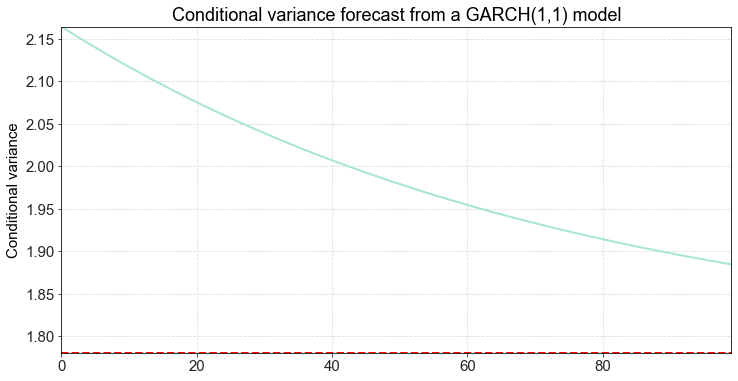

In [144]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(h_forecast)
ax.axhline(y=res.x[1]/(1 - res.x[2] - res.x[3]), color='red', linestyle='--')
#ax.set_ylim([1.58, 1.76])
ax.set_ylabel("Conditional variance")
ax.set_title("Conditional variance forecast from a GARCH(1,1) model");

In [145]:
res.x[2] + res.x[3]                                                   

0.9869076914180448

__1-day value at risk__

Since we already have calculated $h_t$, $t=1,...,T$ then we can just apply the standard formula

$$
\text{VaR} = \mu + \sqrt{h_t} z_{0.05}
$$

where $z_p$ denotes the $p$-percentile. 

In [146]:
h = garch_recursion(res.x[0], res.x[1], res.x[2], res.x[3], sp500_log_returns)

value_at_risk = res.x[0] + stats.norm.ppf(0.05) * np.sqrt(h)

(-15.0, 10.0)

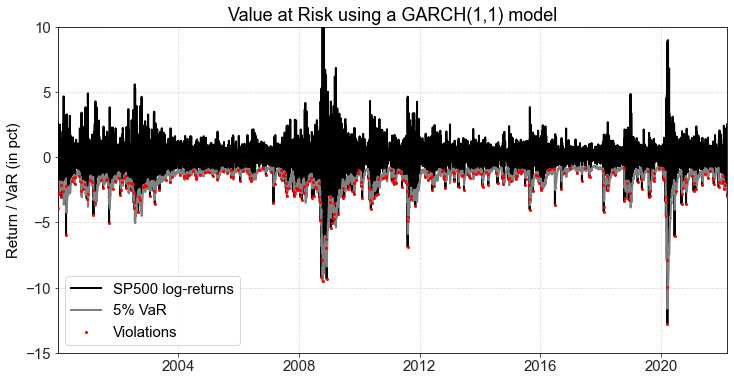

In [148]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_sp500_log_returns.index, sp500_log_returns, color="black", label="SP500 log-returns")
ax.plot(df_sp500_log_returns.index, value_at_risk, color="gray", label="5% VaR")

idx = sp500_log_returns < value_at_risk
ax.scatter(df_sp500_log_returns.index[idx], sp500_log_returns[idx], color="red", zorder=10, s=4, label = "Violations")

ax.scatter
ax.set_ylabel("Return / VaR (in pct)")
ax.set_title("Value at Risk using a GARCH(1,1) model");
ax.legend();

ax.set_ylim([-15, 10])

__Multi-period VaR__


In [29]:
def garch_simulation(mu, omega, alpha, beta, returns, horizon=1, num_sim=1000):
    
    h = garch_recursion(mu, omega, alpha, beta, returns)
    eps_last  = returns[-1]  - mu
    
    sim_data = np.empty((num_sim, horizon))
    random_data = np.random.normal(size=(num_sim, horizon))
    for i in range(num_sim):
        h_forecast = np.empty(horizon)
        for j in range(horizon):
            if j == 0: 
                h_forecast[j] = omega + beta * h[-1] + alpha * eps_last**2
                sim_data[i, j] = np.sqrt(h_forecast[j]) * random_data[i, j]
            else: 
                h_forecast[j] = omega + beta * h_forecast[j-1] + alpha * sim_data[i, j - 1]**2
                sim_data[i, j] = np.sqrt(h_forecast[j]) * random_data[i, j]
                
    return sim_data + mu
            

In [30]:
h_forecast = garch_forecast(res.x[0], res.x[1], res.x[2], res.x[3], sp500_log_returns, horizon=100, multiple=True)

In [31]:
sim_data  = garch_simulation(res.x[0], res.x[1], res.x[2], res.x[3], sp500_log_returns, horizon=100, num_sim=25000)

In [32]:
cum_log_returns = np.cumsum(sim_data, axis=1)

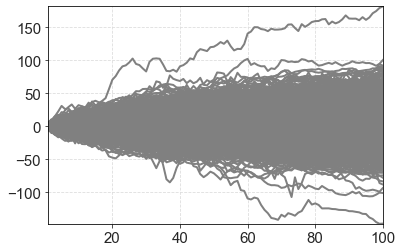

In [33]:
plt.plot(np.arange(1, 101), np.cumsum(sim_data, axis=1).T, color='gray');

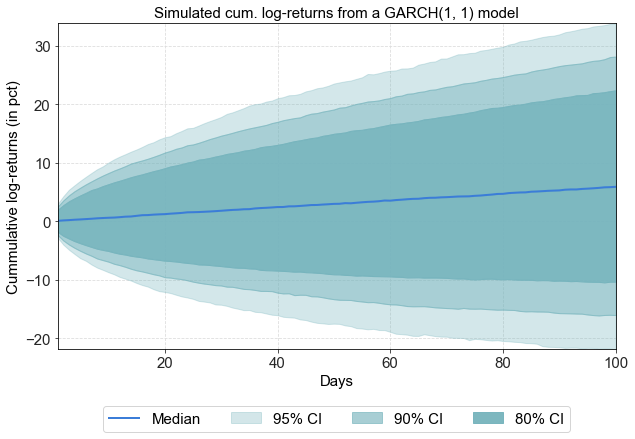

In [34]:
time_points = np.arange(1, 101, 1)

# calculate percentiles
percentiles = np.percentile(cum_log_returns, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Days", size=15)
ax.set_ylabel("Cummulative log-returns (in pct)", size=15)
ax.set_title("Simulated cum. log-returns from a GARCH(1, 1) model", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

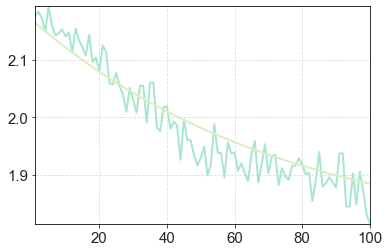

In [35]:
plt.plot(np.arange(1, 101), np.var(sim_data, axis=0));
plt.plot(np.arange(1, 101), h_forecast);

# Problem 2: Historical scenarios and risk management

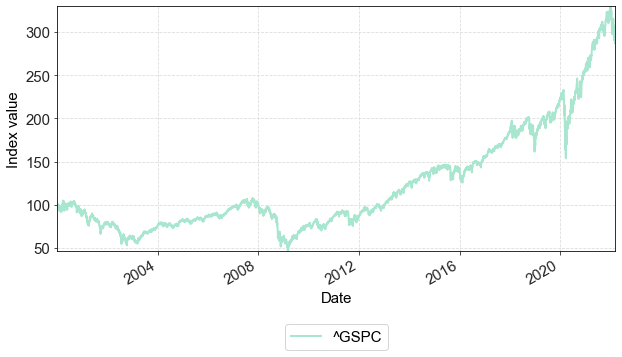

In [81]:
from pandas_datareader.yahoo.daily import YahooDailyReader

"""
Get adjusted index prices for SP500.
"""
tickers = ["^GSPC"]
sp500 = YahooDailyReader(tickers, start=datetime.date(2000, 1, 1)).read()

"""
Get adjusted close and normalize
"""
sp500_adj_close = sp500['Adj Close']
sp500_adj_close = sp500_adj_close / sp500_adj_close.iloc[0, :] * 100

"""
Plot stock prices
"""

ax = sp500_adj_close.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

In [82]:
"""
Calculate log return
"""
df_sp500_adj_log_ret = np.log(sp500_adj_close / sp500_adj_close.shift(1)).dropna()

In [83]:
sp500_log_returns = df_sp500_adj_log_ret.values[:, 0]

"""
Calculate equal probability statistics
"""

stats_dict = {}

stats_dict['Mean'] = np.average(sp500_log_returns) 
stats_dict['Std'] = calculate_std(sp500_log_returns) 
stats_dict['Skewness'] = calculate_skewness(sp500_log_returns) 
stats_dict['Kurtosis'] = calculate_kurtosis(sp500_log_returns) 
stats_dict['5pct'] = weighted_percentile(sp500_log_returns, p = 0.05)

df_statistics = pd.DataFrame(stats_dict, index=['Equal probs'])
df_statistics

,Mean,Std,Skewness,Kurtosis,5pct
Equal probs,0.00019,0.0124,-0.394332,10.912684,-0.019089


## Probabilities as a function of time

In [84]:
def rolling_probs(x: np.ndarray, num_periods: int, last_index: int = None, axis: int = 0) -> np.ndarray:
    """
    Creates an array of equal weights.

    Parameters
    ----------
    x:
        Array for setting the shape of.
    num_periods:
        Number of periods to assign probabilites. 
    last_index: 
        Index of period that will be the last period we assign a positive probability. 
        Default is the index of the last period. 
    axis:
        The axis to create the weights over. Default is 0.

    Returns
    -------
    ndarray
        Array of equal weights.
    """
    
    if axis == 0:
        num_obs = x.shape[0]
    elif axis == 1:
        num_obs = x.shape[1]
    else:
        raise IndexError("Axis parameter is invalid, must be either 0 or 1")
        
    if last_index is None:
        idx_end = num_obs
    else:
        idx_end = min(num_obs, last_index + 1)
        
    idx_start = max(idx_end - num_periods, 0)
    weights = np.zeros(num_obs) 
    weights[idx_start:idx_end] = 1 / (idx_end - idx_start)
        
    return weights

In [85]:
def exponential_probs(x: np.ndarray, decay: float, last_index: int = None, axis: int = 0) -> np.ndarray:
    """
    Creates an array  exponential decaying weights.

    Parameters
    ----------
    x:
        Array for setting the shape of.
    decay:
        Exponential decay factor. 
    last_index: 
        Index of period that will be the last period we assign a positive probability. 
        Default is the index of the last period. 
    axis:
        The axis to create the weights over. Default is 0.

    Returns
    -------
    ndarray
        Array of equal weights.
    """
    
    if axis == 0:
        num_obs = x.shape[0]
    elif axis == 1:
        num_obs = x.shape[1]
    else:
        raise IndexError("Axis parameter is invalid, must be either 0 or 1")
        
    if last_index is None:
        idx_end = num_obs
    else:
        idx_end = min(num_obs, last_index + 1)
        
    idx_start = 0 
    
    weights = np.zeros(num_obs) 
    
    weights[idx_start:idx_end] = np.flip(np.exp(-decay * np.arange(idx_end)))
    weights[idx_start:idx_end] /= np.sum(weights)
    
    return weights

In [86]:
"""
Calculate mean with the last 750 observations
"""
probs_roll = rolling_probs(sp500_log_returns, num_periods=750) 

df_statistics.loc['Rolling probs', 'Mean'] = np.average(sp500_log_returns, weights=probs_roll)
df_statistics.loc['Rolling probs','Std'] = calculate_std(sp500_log_returns, probs=probs_roll) 
df_statistics.loc['Rolling probs','Skewness'] = calculate_skewness(sp500_log_returns, probs=probs_roll) 
df_statistics.loc['Rolling probs','Kurtosis'] = calculate_kurtosis(sp500_log_returns, probs=probs_roll) 
df_statistics.loc['Rolling probs','5pct'] = weighted_percentile(sp500_log_returns, p = 0.05, probs=probs_roll)


In [87]:
df_statistics

,Mean,Std,Skewness,Kurtosis,5pct
Equal probs,0.000190,0.012400,-0.394332,10.912684,-0.019089
Rolling probs,0.000542,0.014504,-1.057119,17.182606,-0.019583


In [88]:
"""
Calculate exponential probabilites corresponding to a half-life of  126 days
"""
decay = 0.0055
probs_exp = exponential_probs(sp500_log_returns, decay=decay)
df_statistics.loc['Exp probs', 'Mean'] = np.average(sp500_log_returns, weights=probs_exp)
df_statistics.loc['Exp probs','Std'] = calculate_std(sp500_log_returns, probs=probs_exp) 
df_statistics.loc['Exp probs','Skewness'] = calculate_skewness(sp500_log_returns, probs=probs_exp) 
df_statistics.loc['Exp probs','Kurtosis'] = calculate_kurtosis(sp500_log_returns, probs=probs_exp) 
df_statistics.loc['Exp probs','5pct'] = weighted_percentile(sp500_log_returns, p = 0.05, probs=probs_exp)

In [89]:
df_statistics

,Mean,Std,Skewness,Kurtosis,5pct
Equal probs,0.000190,0.012400,-0.394332,10.912684,-0.019089
Rolling probs,0.000542,0.014504,-1.057119,17.182606,-0.019583
Exp probs,0.000097,0.011631,-0.616603,11.244252,-0.019144


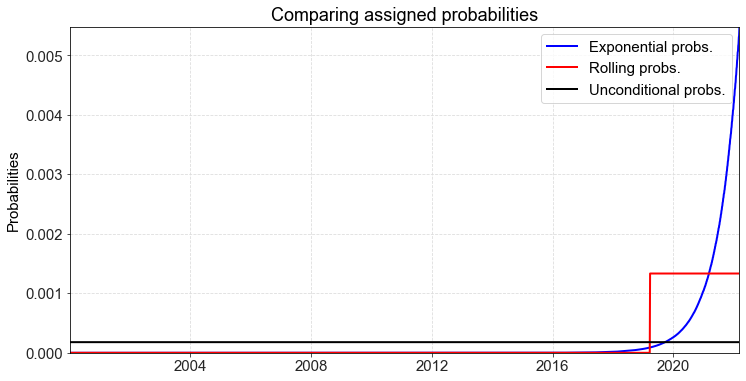

In [90]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_sp500_adj_log_ret.index, probs_exp, label="Exponential probs.", color="blue");
ax.plot(df_sp500_adj_log_ret.index, probs_roll, label="Rolling probs.", color="red")
ax.plot(df_sp500_adj_log_ret.index, np.ones_like(probs_exp) / len(probs_exp), label="Unconditional probs.", color="black")
ax.set_ylabel("Probabilities")
ax.set_title("Comparing assigned probabilities");
ax.legend();

## Probabilities as a function of a state variable


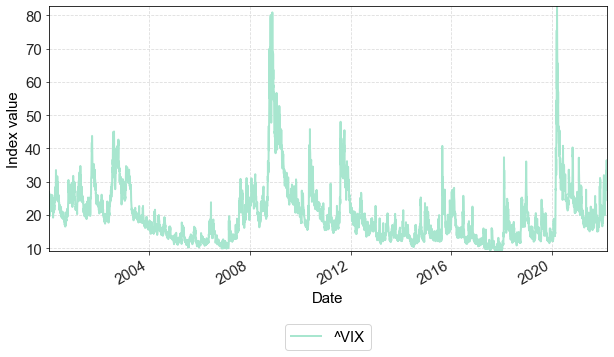

In [100]:
"""
Get VIX index
"""
tickers = ["^VIX"]
df_vix = YahooDailyReader(tickers, start=datetime.date(2000, 1, 1)).read()['Adj Close']
df_vix = df_vix[~df_vix.index.duplicated(keep='first')]
"""
Plot stock prices
"""

ax = df_vix.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

In [102]:
"""
Make sure that dates are the same 
"""

df_vix = df_vix.loc[df_sp500_adj_log_ret.index, :]

In [103]:
def crisp_conditioning_probs(x: np.ndarray, condition: Tuple = (-np.inf, np.inf), axis: int = 0) -> np.ndarray:
    
    """
    Creates an array of crisp condition probabilities. 
    
    Currently only works for one state variable. 
    
    Parameters
    ----------
    x:
        Array for setting the shape of.
    condition:
        Tuple with lower and upper bound. 
    axis:
        The axis to create the weights over. Default is 0.

    Returns
    -------
    ndarray
        Array of equal weights.
    """
    
    probs = (x >= condition[0]) & (x <= condition[1])
    probs = probs / np.sum(probs)
    
    return probs

In [104]:
"""
Calculate probabilites
"""
vix = df_vix.values[:, 0]
probs_crisp = crisp_conditioning_probs(vix, condition=(25.0, np.inf)) 

In [105]:
df_statistics.loc['Crisp probs', 'Mean'] = np.average(sp500_log_returns, weights=probs_crisp)
df_statistics.loc['Crisp probs','Std'] = calculate_std(sp500_log_returns, probs=probs_crisp) 
df_statistics.loc['Crisp probs','Skewness'] = calculate_skewness(sp500_log_returns, probs=probs_crisp) 
df_statistics.loc['Crisp probs','Kurtosis'] = calculate_kurtosis(sp500_log_returns, probs=probs_crisp) 
df_statistics.loc['Crisp probs','5pct'] = weighted_percentile(sp500_log_returns, p = 0.05, probs=probs_crisp)

In [106]:
df_statistics

,Mean,Std,Skewness,Kurtosis,5pct
Equal probs,0.000190,0.012400,-0.394332,10.912684,-0.019089
Rolling probs,0.000542,0.014504,-1.057119,17.182606,-0.019583
Exp probs,0.000097,0.011631,-0.616603,11.244252,-0.019144
Crisp probs,-0.002171,0.022130,-0.052245,3.356134,-0.034913


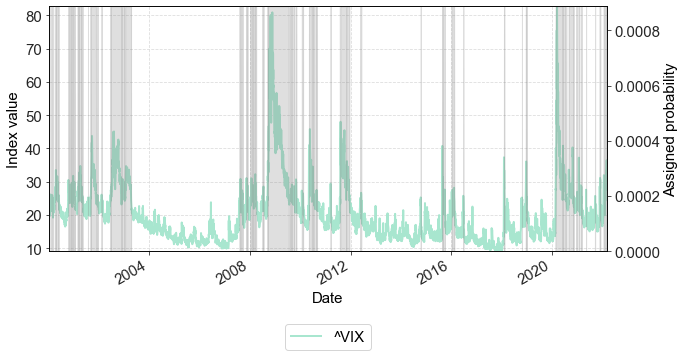

In [107]:
ax = df_vix.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

ax_new = ax.twinx()

ax_new.fill_between(df_vix.index, probs_crisp, color="gray", alpha=0.25)
ax_new.set_ylabel("Assigned probability")
ax_new.grid(None)

In [108]:
def smoothed_conditioning_probs(x: np.ndarray, target: float, std: float, axis: int = 0) -> np.ndarray:
    
    """
    Creates an array of smoothed conditioning probabilities. 
    
    Currently only works for one state variable. 
    
    Parameters
    ----------
    x:
        Array for setting the shape of.
    target: 
        Target value of state variable. 
    std:
        Bandwith.
    axis:
        The axis to create the weights over. Default is 0.

    Returns
    -------
    ndarray
        Array of equal weights.
    """
    
    probs = np.exp(-(x-target)**2 / (2 * std**2))
    probs = probs / np.sum(probs)
    
    return probs

In [110]:
probs_smooth = smoothed_conditioning_probs(vix, target=35, std=5) 

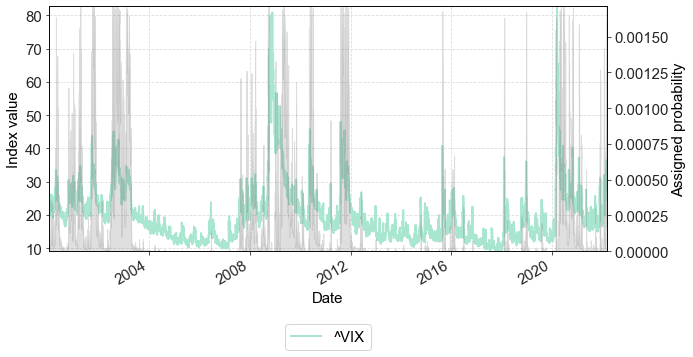

In [111]:
ax = df_vix.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

ax_new = ax.twinx()

ax_new.fill_between(df_vix.index, probs_smooth, color="gray", alpha=0.25)
ax_new.set_ylabel("Assigned probability")
ax_new.grid(None)

In [112]:
df_statistics.loc['Smooth probs', 'Mean'] = np.average(sp500_log_returns, weights=probs_smooth)
df_statistics.loc['Smooth probs','Std'] = calculate_std(sp500_log_returns, probs=probs_smooth) 
df_statistics.loc['Smooth probs','Skewness'] = calculate_skewness(sp500_log_returns, probs=probs_smooth) 
df_statistics.loc['Smooth probs','Kurtosis'] = calculate_kurtosis(sp500_log_returns, probs=probs_smooth) 
df_statistics.loc['Smooth probs','5pct'] = weighted_percentile(sp500_log_returns, p = 0.05, probs=probs_smooth)

In [113]:
df_statistics

,Mean,Std,Skewness,Kurtosis,5pct
Equal probs,0.000190,0.012400,-0.394332,10.912684,-0.019089
Rolling probs,0.000542,0.014504,-1.057119,17.182606,-0.019583
Exp probs,0.000097,0.011631,-0.616603,11.244252,-0.019144
Crisp probs,-0.002171,0.022130,-0.052245,3.356134,-0.034913
Smooth probs,-0.001401,0.018413,0.125202,0.368507,-0.030052


In [114]:
"""
Fully flexible probabilities
"""

init_probs = np.ones_like(vix)
init_probs = init_probs / np.sum(init_probs)

mean_view = MeanView('eq', vix, 30)

all_views = [mean_view]

view_solver = ProbabilitySolver(init_probs, all_views)
view_probs = view_solver.minimize_entropy()

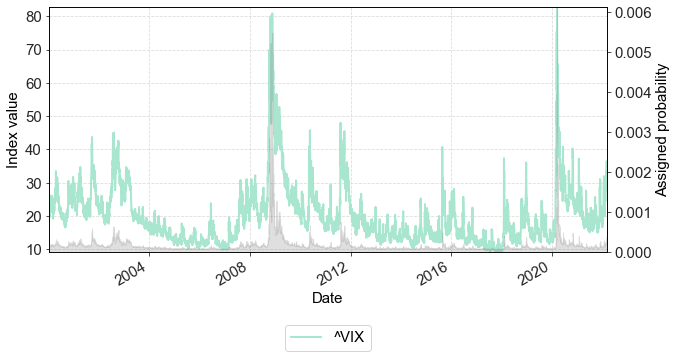

In [115]:
ax = df_vix.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

ax_new = ax.twinx()

ax_new.fill_between(df_vix.index, view_probs, color="gray", alpha=0.25)
ax_new.set_ylabel("Assigned probability")
ax_new.grid(None)

In [116]:
df_statistics.loc['FFV probs', 'Mean'] = np.average(sp500_log_returns, weights=view_probs)
df_statistics.loc['FFV probs','Std'] = calculate_std(sp500_log_returns, probs=view_probs) 
df_statistics.loc['FFV probs','Skewness'] = calculate_skewness(sp500_log_returns, probs=view_probs) 
df_statistics.loc['FFV probs','Kurtosis'] = calculate_kurtosis(sp500_log_returns, probs=view_probs) 
df_statistics.loc['FFV probs','5pct'] = weighted_percentile(sp500_log_returns, p = 0.05, probs=view_probs)

In [117]:
df_statistics

,Mean,Std,Skewness,Kurtosis,5pct
Equal probs,0.000190,0.012400,-0.394332,10.912684,-0.019089
Rolling probs,0.000542,0.014504,-1.057119,17.182606,-0.019583
Exp probs,0.000097,0.011631,-0.616603,11.244252,-0.019144
Crisp probs,-0.002171,0.022130,-0.052245,3.356134,-0.034913
Smooth probs,-0.001401,0.018413,0.125202,0.368507,-0.030052
FFV probs,-0.002974,0.025389,-0.894592,6.268047,-0.045875


# Literature

[Bollerslev (1986), Generalized autoregressive conditional heteroskedasticity](https://www.sciencedirect.com/science/article/abs/pii/0304407686900631). 

[Attilio Meucci (2010), Historical Scenarios with Fully Flexible Probabilities](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1696802)

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325)

[Attilio Meucci (2012), Effective Number of Scenarios in Fully Flexible Probabilities](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1971808)